In [1]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import wget
#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#helper function
url =  'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [3]:
spices_data = 'D:\ML\Spices_Clasification_update'
walk_through_dir(spices_data)

There are 26 directories and 0 images in 'D:\ML\Spices_Clasification_update'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\adas'.
There are 0 directories and 195 images in 'D:\ML\Spices_Clasification_update\andaliman'.
There are 0 directories and 201 images in 'D:\ML\Spices_Clasification_update\asam_jawa'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\biji_ketumbar'.
There are 0 directories and 136 images in 'D:\ML\Spices_Clasification_update\bukan_rempah'.
There are 0 directories and 200 images in 'D:\ML\Spices_Clasification_update\bunga_lawang'.
There are 0 directories and 202 images in 'D:\ML\Spices_Clasification_update\cengkeh'.
There are 0 directories and 215 images in 'D:\ML\Spices_Clasification_update\daun_ketumbar'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\daun_salam'.
There are 0 directories and 206 images in 'D:\ML\Spices_Clasification_update\jahe'.
There are 0 directories and 1

In [4]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

Filepath        Label
0      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
1      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
2      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
3      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
4      D:\ML\Spices_Clasification_update\adas\adas-00...         adas
...                                                  ...          ...
10285  D:\ML\Spices_Clasification_update\kayu manis\I...   kayu manis
10286  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10287  D:\ML\Spices_Clasification_update\kayu secang\...  kayu secang
10288  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri
10289  D:\ML\Spices_Clasification_update\kemiri\Image...       kemiri

[10290 rows x 2 columns]

**VISUALIZE THE DATASET**

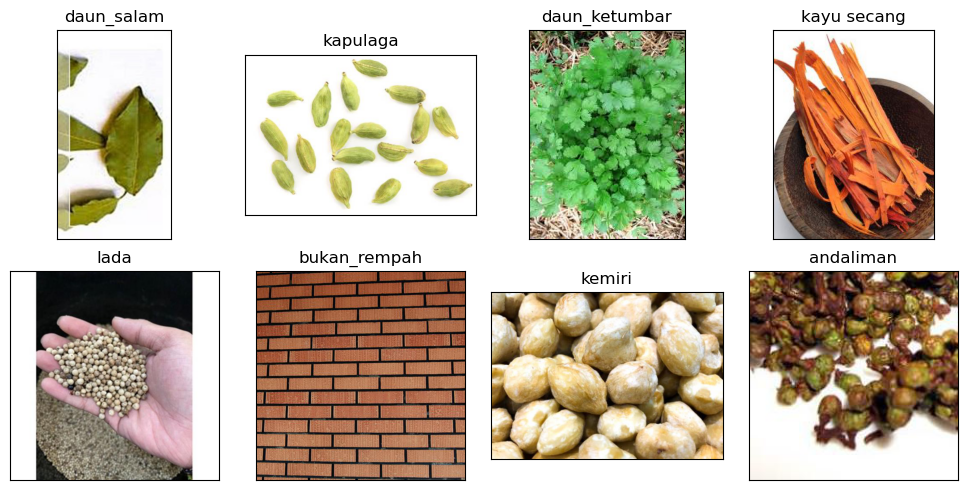

In [6]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [7]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=2)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [9]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 6586 validated image filenames belonging to 26 classes.
Found 1646 validated image filenames belonging to 26 classes.
Found 2058 validated image filenames belonging to 26 classes.


In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    tf.keras.layers.RandomBrightness(0.4),
    tf.keras.layers.RandomContrast(factor=0.4),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.4),
    preprocessing.RandomZoom(0.5),
    preprocessing.RandomHeight(0.5),
    preprocessing.RandomWidth(0.4),
], name="data_augmentation")

In [11]:
input_shape = (224, 224, 3)

# Membuat model MobileNetV3Small
Base_Model = tf.keras.applications.MobileNetV3Small(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
Base_Model.trainable = False
# trainable_layers = Base_Model.layers[-12:]
# for layer in Base_Model:
#     layer.trainable = False

In [12]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=10,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [13]:
checkpoint_path = "spices classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler
def build_model(base_model, num_classes):
    input_tensor = base_model.input
    x = resize_and_rescale(input_tensor)
    x = augmented(x)
    x = Dense(256, activation='relu')(base_model.output)
    x = Dense(128, activation='relu')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=outputs)
    return model

# Menambahkan layer konvolusi setelah base_model
model = build_model(Base_Model, 26)
#learning_rate_scheduler
# def lr_scheduler(epoch,lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
model = build_model(Base_Model,26)
opt = Adam(learning_rate = 1e-04)
# lr_scheduler = LearningRateScheduler(lr_scheduler)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    
)


In [15]:
# Melatih model
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=50,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/50
206/206 [==============================] - 322s 1s/step - loss: 2.9552 - accuracy: 0.1685 - val_loss: 2.2281 - val_accuracy: 0.5249
Epoch 2/50
206/206 [==============================] - 285s 1s/step - loss: 1.9620 - accuracy: 0.4655 - val_loss: 1.3480 - val_accuracy: 0.7193
Epoch 3/50
206/206 [==============================] - 274s 1s/step - loss: 1.4129 - accuracy: 0.6116 - val_loss: 0.9653 - val_accuracy: 0.7795
Epoch 4/50
206/206 [==============================] - 286s 1s/step - loss: 1.1300 - accuracy: 0.6792 - val_loss: 0.7713 - val_accuracy: 0.8190
Epoch 5/50
206/206 [==============================] - 280s 1s/step - loss: 0.9465 - accuracy: 0.7305 - val_loss: 0.6565 - val_accuracy: 0.8414
Epoch 6/50
206/206 [==============================] - 284s 1s/step - loss: 0.8063 - accuracy: 0.7724 - val_loss: 0.5661 - val_accuracy: 0.8584
Epoch 7/50
206/206 [==============================] - 282s 1s/step - loss: 0.7237 - accuracy: 0.7921 - val_loss: 0.5113 - val_accuracy: 0.8657

In [16]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

65/65 - 72s - loss: 0.1569 - accuracy: 0.9475 - 72s/epoch - 1s/step
    Test Loss: 0.15692
Test Accuracy: 94.75%


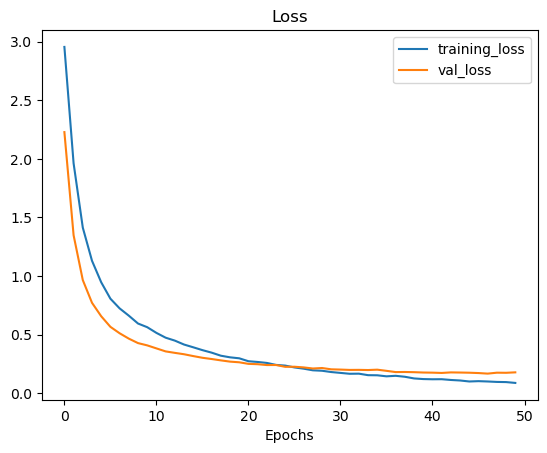

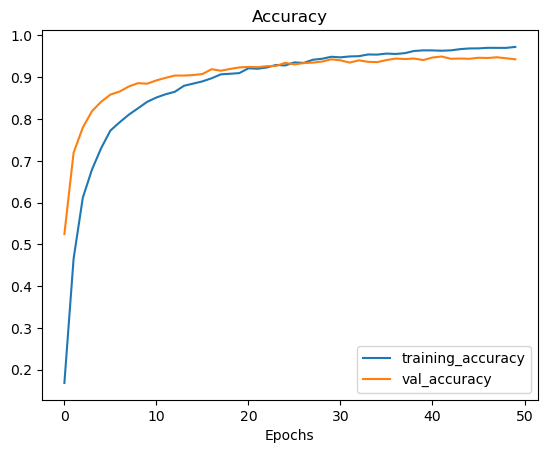

In [17]:
plot_loss_curves(history)

In [18]:
model.save('train_model_mobileNetV3_New5.h5')

C:\Users\Dany\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
history.history #Return Dictionary of history

{'loss': [2.9552321434020996,
  1.9620407819747925,
  1.4128526449203491,
  1.1300368309020996,
  0.9465382695198059,
  0.8062993884086609,
  0.7236784100532532,
  0.6614985466003418,
  0.5944201350212097,
  0.5630960464477539,
  0.5144975781440735,
  0.47357869148254395,
  0.44858333468437195,
  0.4150526225566864,
  0.39155396819114685,
  0.3672945201396942,
  0.34584611654281616,
  0.3197691738605499,
  0.30592238903045654,
  0.297563761472702,
  0.27257901430130005,
  0.2663159668445587,
  0.2580375671386719,
  0.241191565990448,
  0.23531566560268402,
  0.2195926159620285,
  0.20901836454868317,
  0.1950673907995224,
  0.19125811755657196,
  0.1802753061056137,
  0.1729210615158081,
  0.1655144989490509,
  0.1664186418056488,
  0.15357966721057892,
  0.15260523557662964,
  0.14368776977062225,
  0.14813072979450226,
  0.13998644053936005,
  0.1257336437702179,
  0.12035391479730606,
  0.11859899759292603,
  0.1191624328494072,
  0.11260171979665756,
  0.10819981247186661,
  0.0997

In [20]:
#Recording History in json
import json
with open('train_hist_mobileNetV3_New5.json','w') as f:
  json.dump(history.history,f)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 94.28918361663818 %


In [29]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

65/65 [==============================] - 77s 1s/step
The first 5 predictions: ['kayu secang', 'pala', 'kayu secang', 'lada', 'kencur']


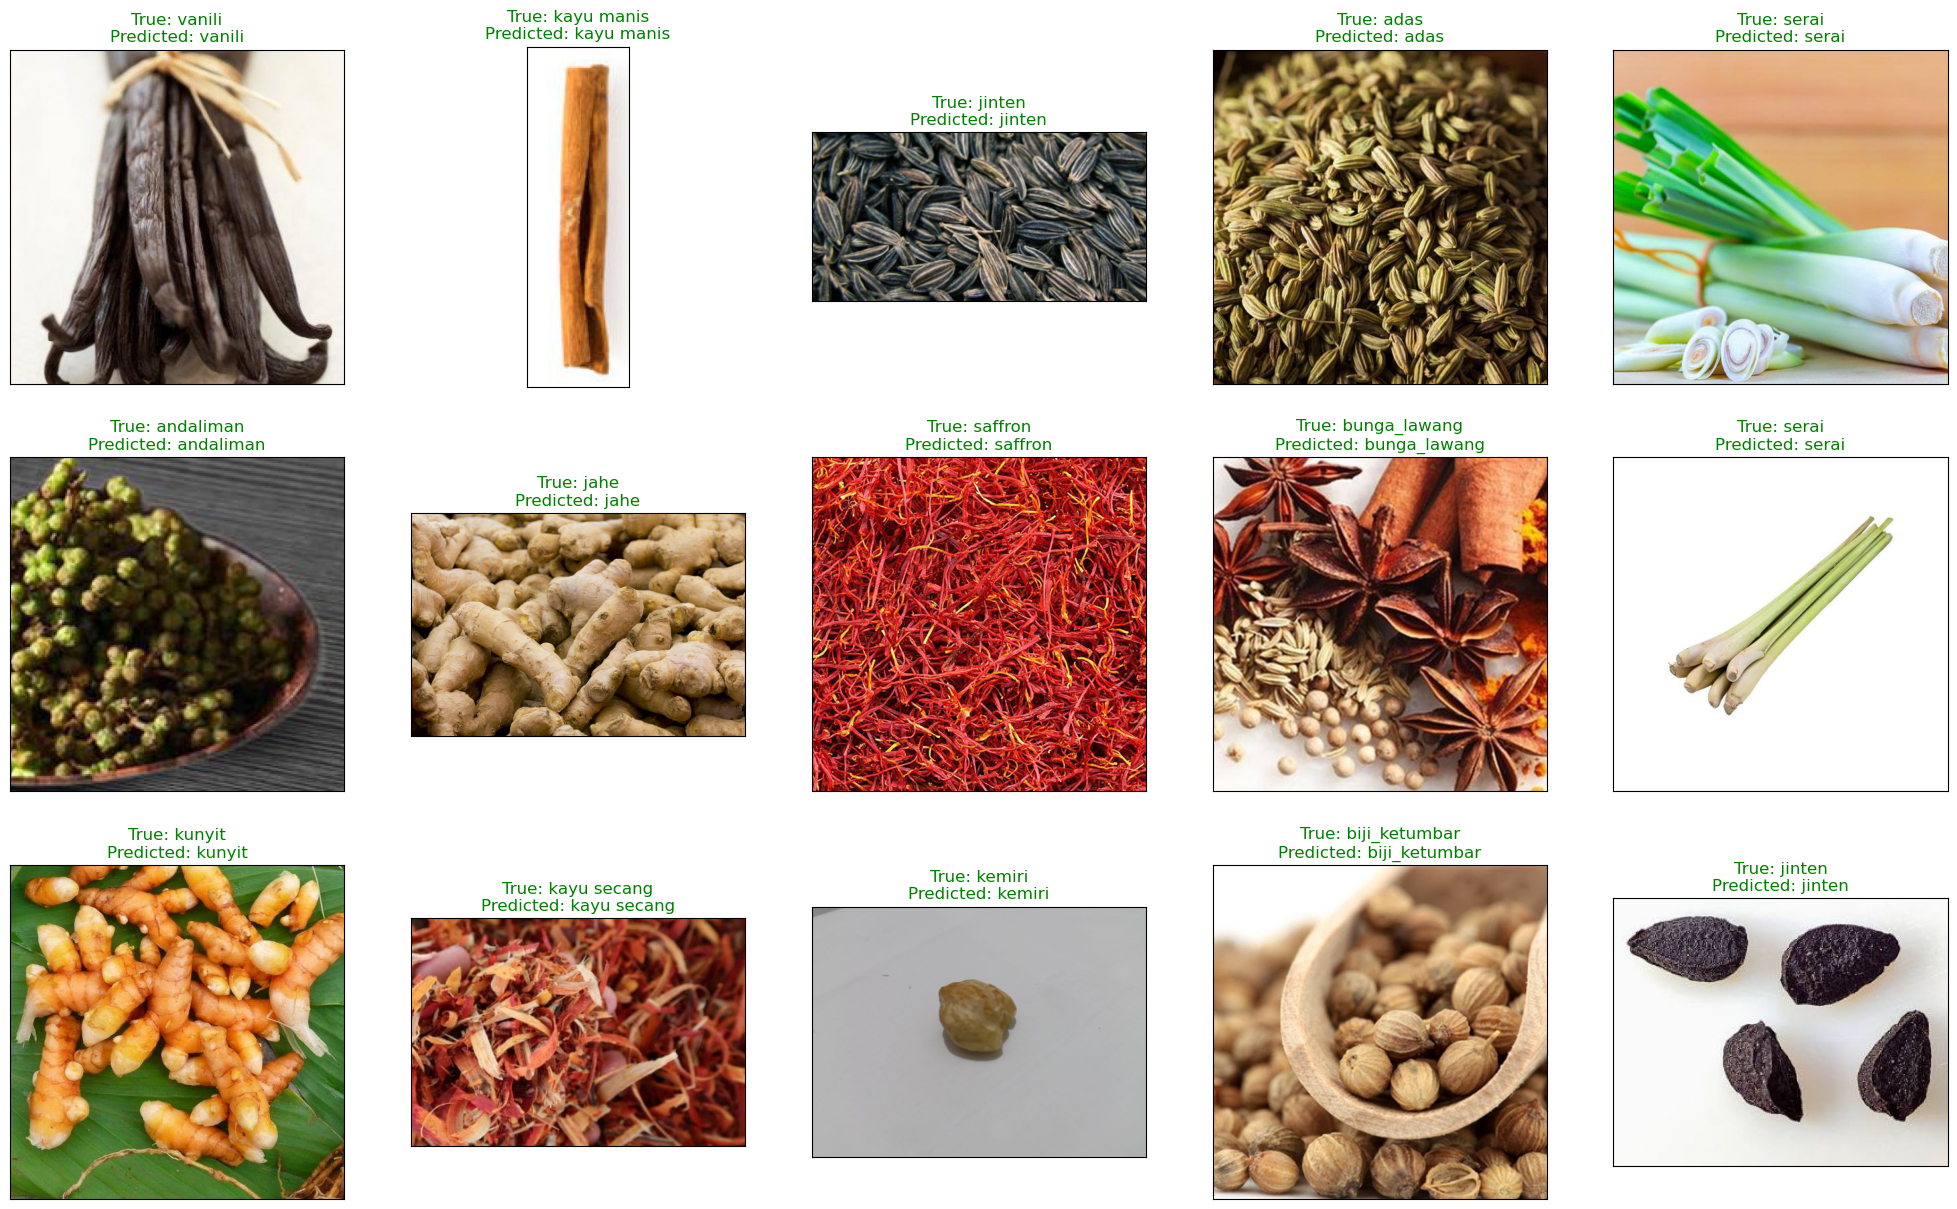

<Figure size 640x480 with 0 Axes>

In [32]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [27]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       0.94      1.00      0.97        80
    andaliman       0.97      1.00      0.99        67
    asam_jawa       0.93      0.97      0.95        71
biji_ketumbar       0.97      0.79      0.87        92
 bukan_rempah       1.00      0.95      0.98        66
 bunga_lawang       0.98      0.98      0.98        60
      cengkeh       0.96      0.99      0.97        96
daun_ketumbar       1.00      1.00      1.00        79
   daun_salam       0.89      0.94      0.92        81
         jahe       0.93      0.89      0.91        80
       jinten       0.98      0.95      0.96        83
     kapulaga       0.92      0.92      0.92        64
   kayu manis       0.87      0.90      0.88        96
  kayu secang       0.98      1.00      0.99        63
       kemiri       0.97      0.77      0.86        99
      kemukus       1.00      0.99      0.99        72
       kencur       0.98      0.92      0.95        89
       kl